In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jupyterlab"

***
## loading data

In [2]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet("../ump-dataset/train.parquet", columns=features)
target = pd.read_parquet("../ump-dataset/train.parquet", columns=["target",])
time = pd.read_parquet("../ump-dataset/train.parquet", columns=["time_id",])

In [3]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [4]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.3
valid_size = int(valid_prop * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 363


In [5]:
valid_time_ids = time_ids[-valid_size:]

In [6]:
train_idx = time.query("time_id not in @valid_time_ids").index
valid_idx = time.query("time_id in @valid_time_ids").index

# dataframes for metric calculation
oof = target.loc[valid_idx,:].copy()
oof["time_id"] = time.loc[valid_idx,"time_id"]
features_valid = features.loc[valid_idx,:]

# input dataset for lgbm
train_dset = lgb.Dataset(
    data=features.loc[train_idx,:],
    label=target.loc[train_idx,"target"].values,
    free_raw_data=True
)
valid_dset = lgb.Dataset(
    data=features.loc[valid_idx,:],
    label=target.loc[valid_idx,"target"].values,
    free_raw_data=True
)

In [7]:
import gc
gc.collect()

35

***
## Bayesian Optimization

In [8]:
default_params = {
    'boosting': 'dart',
    'linear_tree':True,
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'max_bin':511,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': int(1e8),
    'feature_pre_filter' : False,
}

In [9]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [10]:
def objective(trial):    
    sampled_params = dict(
        feature_fraction = trial.suggest_discrete_uniform("feature_fraction", 0.1, 0.4, 0.05),
        bagging_fraction = trial.suggest_discrete_uniform("bagging_fraction", 0.9, 1.0, 0.05),
        lambda_l1 = trial.suggest_loguniform("lambda_l1", 1e-3, 1e2),
        lambda_l2 = trial.suggest_loguniform("lambda_l2", 1e-3, 1e2),
        linear_lambda = trial.suggest_float("linear_lambda", 0., 500.),
        path_smooth = trial.suggest_float("path_smooth", 0., 50.),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1000, 5000, 100),
        # dart params
        drop_rate = trial.suggest_discrete_uniform("drop_rate", 0.05, 0.2, 0.01),
        max_drop = trial.suggest_int("max_drop", 5, 50, 5),
        skip_drop = trial.suggest_discrete_uniform("skip_drop", 0.1, 0.9, 0.05),  
    )
    model_params = {**default_params, **sampled_params}
        
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        num_boost_round=trial.suggest_int("num_iterations", 500, 3000, 100),
    )
    
    # metric calculation
    _oof = oof.copy()
    _oof["pred"] = model.predict(features_valid)
    corrs = _oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    
    return corr_mean            

In [11]:
do_optimize = False

study = optuna.create_study(
    study_name="lgbm-linear-dart",
    direction='maximize',
    storage='sqlite:///lgbm-linear-dart.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=172800, # 48-hrs
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2022-03-23 15:34:18,381] Using an existing study with name 'lgbm-linear-dart' instead of creating a new one.


In [12]:
study.trials_dataframe().sort_values("value", ascending=False).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_drop_rate,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_linear_lambda,params_max_drop,params_min_data_in_leaf,params_num_iterations,params_path_smooth,params_skip_drop,state
202,202,0.136737,2022-03-15 17:21:09.460931,2022-03-15 17:29:05.785629,0 days 00:07:56.324698,1.00,0.05,0.15,3.260815,24.657155,15.831719,5,2200,1900,4.714076,0.65,COMPLETE
283,283,0.136315,2022-03-16 05:56:57.363954,2022-03-16 06:04:47.247904,0 days 00:07:49.883950,1.00,0.05,0.15,0.007566,22.105496,55.960023,5,1700,1900,4.380527,0.65,COMPLETE
188,188,0.136161,2022-03-15 15:26:12.563488,2022-03-15 15:34:25.596320,0 days 00:08:13.032832,1.00,0.07,0.15,0.407263,2.887974,23.684422,5,2200,1800,0.661187,0.60,COMPLETE
162,162,0.136126,2022-03-15 11:06:29.983089,2022-03-15 11:17:20.487791,0 days 00:10:50.504702,1.00,0.07,0.15,21.202663,11.868376,191.387296,10,2100,1800,7.344292,0.65,COMPLETE
230,230,0.136112,2022-03-15 21:49:21.836110,2022-03-15 21:56:30.746542,0 days 00:07:08.910432,1.00,0.07,0.15,0.040167,46.594280,96.509349,5,2300,1800,1.991219,0.70,COMPLETE
183,183,0.135998,2022-03-15 14:47:35.303320,2022-03-15 14:55:15.752867,0 days 00:07:40.449547,1.00,0.06,0.15,0.001418,0.085185,41.714472,5,2200,1800,2.318433,0.65,COMPLETE
317,317,0.135951,2022-03-16 10:38:29.327470,2022-03-16 10:46:38.535645,0 days 00:08:09.208175,1.00,0.05,0.15,0.616362,0.146977,0.662847,5,2500,1800,3.684586,0.60,COMPLETE
293,293,0.135902,2022-03-16 07:29:56.979565,2022-03-16 07:38:11.841124,0 days 00:08:14.861559,1.00,0.05,0.15,0.003667,18.630969,269.125390,5,1800,2000,8.008293,0.65,COMPLETE
171,171,0.135890,2022-03-15 12:37:04.815818,2022-03-15 12:47:44.609608,0 days 00:10:39.793790,1.00,0.07,0.15,0.619489,18.140712,88.460764,10,2100,1800,6.839777,0.65,COMPLETE
282,282,0.135852,2022-03-16 05:45:34.893676,2022-03-16 05:56:57.262479,0 days 00:11:22.368803,1.00,0.05,0.15,0.529465,0.498891,42.583428,10,1800,1900,2.414366,0.65,COMPLETE


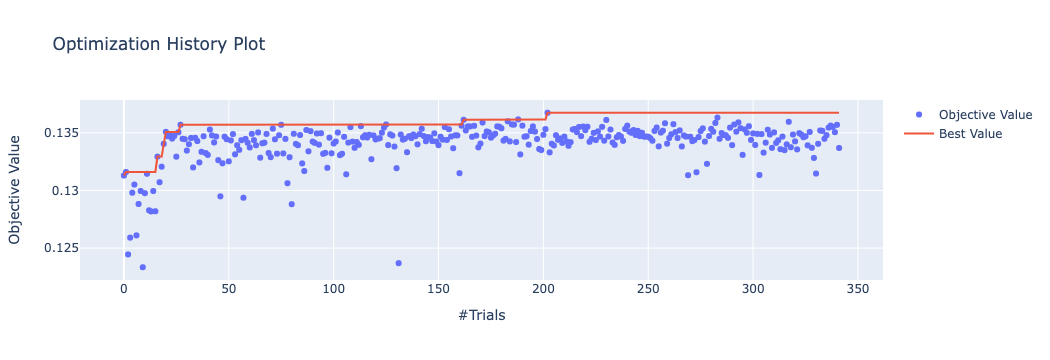

In [13]:
plot_optimization_history(study)

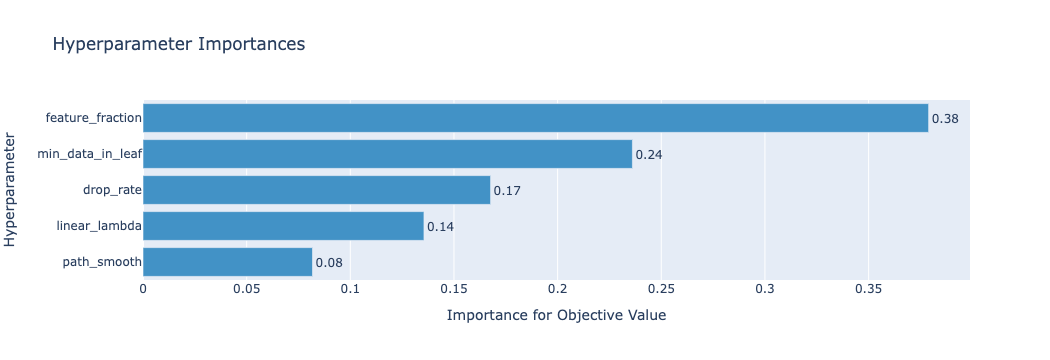

In [14]:
plot_param_importances(study)

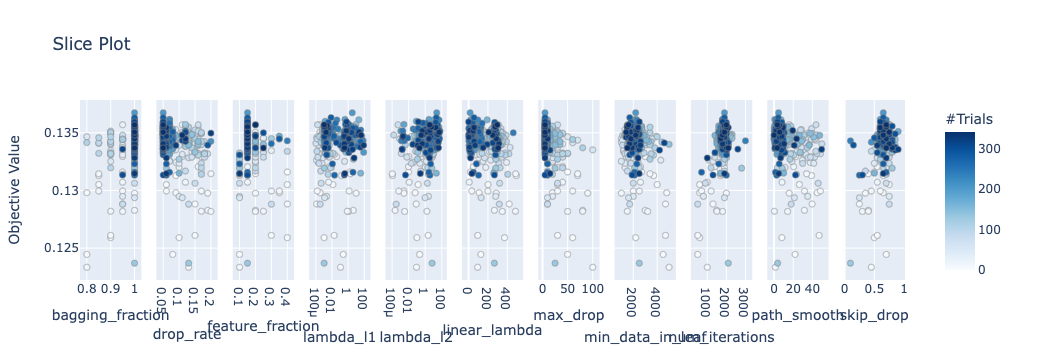

In [15]:
plot_slice(study)

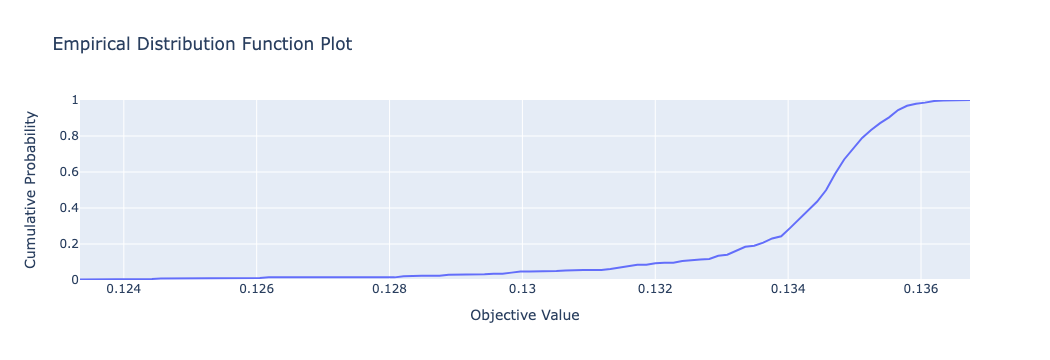

In [16]:
plot_edf(study)

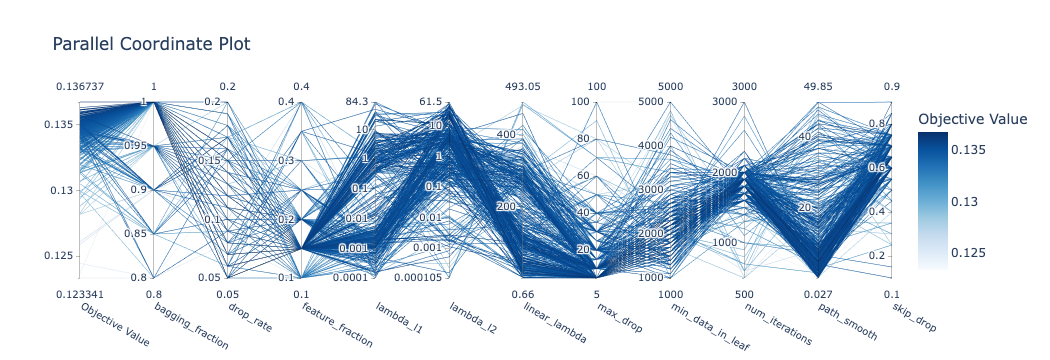

In [17]:
plot_parallel_coordinate(study)

In [18]:
best_params = dict(study.best_params)
best_params = {**default_params, **best_params}
best_params

{'boosting': 'dart',
 'linear_tree': True,
 'objective': 'mse',
 'metric': 'rmse',
 'learning_rate': 0.05,
 'num_leaves': 32,
 'max_bin': 511,
 'force_col_wise': True,
 'bagging_freq': 1,
 'seed': 19,
 'verbosity': -1,
 'first_metric_only': False,
 'bin_construct_sample_cnt': 100000000,
 'feature_pre_filter': False,
 'bagging_fraction': 1.0,
 'drop_rate': 0.05,
 'feature_fraction': 0.15000000000000002,
 'lambda_l1': 3.2608153782775893,
 'lambda_l2': 24.65715474841406,
 'linear_lambda': 15.831719022196562,
 'max_drop': 5,
 'min_data_in_leaf': 2200,
 'num_iterations': 1900,
 'path_smooth': 4.714076496843463,
 'skip_drop': 0.65}

***